In [3]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from flt3_data_loading import km_normed_1, flt3_filtered

In [5]:
# Oversampling
# 132 positive, 320 negative => 320 positive, 320 negative
rand.seed(0)
positive_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
new_positives = pd.DataFrame([[0.0 for j in range(km_normed_1.shape[1])] for i in range(320)])
new_positives.columns = km_normed_1.columns
for i in range(320):
    r = rand.randrange(0, len(positive_indices))
    new_positives.iloc[i] = km_normed_1.iloc[r]
    
# Combine with negative examples then shuffle
negatives = km_normed_1[np.array(flt3_filtered) == 0].set_index(new_positives.index.values)
over_combined = pd.concat([new_positives, negatives]).set_index(np.array(range(640)))
over_combined['label'] = np.array([1 for i in range(320)] + [0 for i in range(320)])
over_combined = over_combined.sample(frac=1, random_state=0).reset_index(drop=True)
oc_flt3 = over_combined.label
over_combined = over_combined.drop(['label'], axis=1)

In [6]:
# Data loading
num_workers = 0
batch_size = 64
valid_size = 0.2

data = []
for i in range(len(over_combined)):
    data.append([np.array(over_combined.iloc[i], dtype='f'), oc_flt3[i]])

num_train = len(over_combined)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [13]:
# Model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [ ]:
%pdb

In [20]:
%%time
n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_adam.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_adam_final.pt')

Epoch: 2253	Train: 0.6936404183506966	Val: 0.6940101683139801	Min Val: 0.6930999159812927

KeyboardInterrupt: 

In [21]:
# Final model
model = Net()
model.load_state_dict(torch.load('model_files/model_adam_final.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    print(pred)
    print(target)
print(score/(valid_size*10))

FileNotFoundError: [Errno 2] No such file or directory: 'model_adam_final.pt'

In [22]:
# Saved best model
model = Net()
model.load_state_dict(torch.load('model_files/model_adam.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    print(pred)
    print(target)
print(score/(valid_size*10))

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])
0.557076758231054


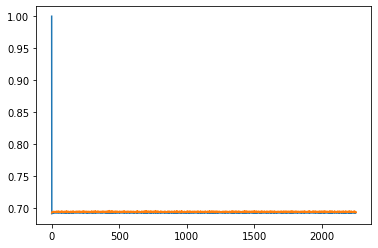

In [23]:
# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 999	Train: 0.2576644476503134	Val: 1.2058981657028198	Min Val: 0.57301682233810422
 0.7840583918261543

 0.7432598039215687


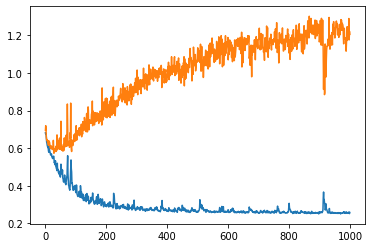

CPU times: user 29min 50s, sys: 1h 50min 8s, total: 2h 19min 59s
Wall time: 3min 41s


In [7]:
%%time
# adam, 3 layers, lr=0.001, RELU, no dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_6.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_6.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_6.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_6.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 999	Train: 0.3474644999951124	Val: 1.0456282198429108	Min Val: 0.53059829771518711
 0.7774358974358975

 0.7591816785365173


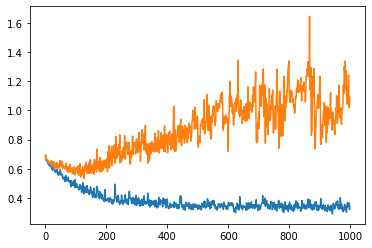

CPU times: user 50min 9s, sys: 3h 4min 14s, total: 3h 54min 24s
Wall time: 7min 24s


In [8]:
%%time
# adam, 3 layers, lr=0.001, RELU, dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_6.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_6.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_6.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_6.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

In [13]:
%%time
# adam 3 layers sigmoid lr=0.01 and dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 10000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_10.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_10.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_10.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_10.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 9999	Train: 0.6931195706129074	Val: 0.6937660872936249	Min Val: 0.6921153664588928

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

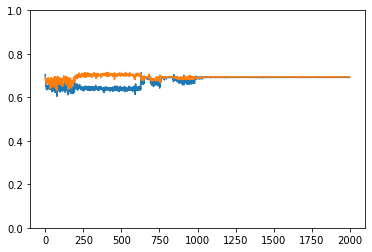

In [12]:
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()

In [14]:
%%time
# adam 5 layers sigmoid lr=0.01 and dropout=0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 5000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_10.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final_10.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_final_10.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Saved best model
model.load_state_dict(torch.load('model_files/model_10.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.show()

Epoch: 2541	Train: 0.6933987587690353	Val: 0.6941153407096863	Min Val: 0.6926231682300568

KeyboardInterrupt: 

In [15]:
# Saved best model
model.load_state_dict(torch.load('model_files/model_10.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    #print(pred)
    #print(target)
print('\n', score/(valid_size*10))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

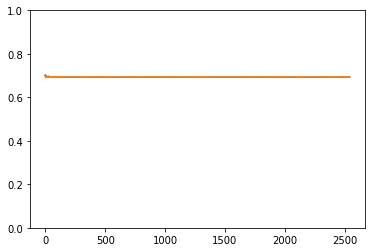

In [16]:
# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()